# All code regarding the paper is in this notebook.

## HistGradientBoostingRegressor

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.mixture import GaussianMixture
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, make_scorer
import os
import sys
from joblib import dump

# Please Change the paths to match your own enviroment.(in case of failure that is)
DATA_PATH = 'Total_Data.csv'

CURRENT_MODEL = "HistGradientBoostingRegressor";

RESULT_DIR = os.path.join(os.getcwd(), f'TrainingResults/Models/{CURRENT_MODEL}/')
os.makedirs(RESULT_DIR, exist_ok=True)

mainData = pd.read_csv(DATA_PATH);

mainData = mainData[['Cancer Type', 'Coumarin Type', 'Coumarin Dose', 'Time', 'Viability']].dropna();

allowed_times_NoAuraptene = [24, 48, 72]
allowed_times_ForAuraptene = [24, 48, 72, 96]

coumarins = ['Auraptene', 'Esculetin', 'Galbanic Acid', 'Umbelliprenin'];

# ====<Pre-Processing and GMM filtering>====

#First filter the main data and save it in data.
cancer_counts = mainData['Cancer Type'].value_counts().to_dict()
count_df = pd.DataFrame(list(cancer_counts.items()), columns=['Cancer Type', 'Sample Count'])

#Initialize the gmm model
gmm = GaussianMixture(n_components=2, random_state=42);
gmm.fit(count_df[['Sample Count']])
threshold = np.mean(gmm.means_.flatten())

count_df['Reliability'] = count_df['Sample Count'].apply(
    lambda x: 'Reliable' if x >= threshold else 'Unreliable'
)

reliable_cancers = count_df[count_df['Reliability'] == 'Reliable']['Cancer Type'].tolist()
reliable_data = mainData[mainData['Cancer Type'].isin(reliable_cancers)].copy()

data = reliable_data;
CancerType_Encoder = LabelEncoder();
CoumarinType_Encoder = LabelEncoder();

data['Coumarin Type'] = CoumarinType_Encoder.fit_transform(data['Coumarin Type'])
data['Cancer Type'] = CancerType_Encoder.fit_transform(data['Cancer Type'])

# Filter out the unneeded times for the general data
data = data[
    ((data['Coumarin Type'] == 'Auraptene') & data['Time'].isin(allowed_times_ForAuraptene)) |
    ((data['Coumarin Type'] != 'Auraptene') & data['Time'].isin(allowed_times_NoAuraptene))
]


# Wether we intend to do grid searching on the model or not is denoted the variable below:
DO_GRIDSEARCH = False;

# Set your X and y here, incase you want general training or training on a specific coumarin.

X = data[['Cancer Type', 'Coumarin Type', 'Coumarin Dose', 'Time']].copy(); # Order must be ['Cancer Type', 'Coumarin Type', 'Coumarin Dose', 'Time']
y = data['Viability'].copy(); # Viability column

# ====<BEGIN GRID SEARCHING>====
# Grid searching is done here, the program stops after grid searching and the parameters and the scores are all saved in reports directory:
if DO_GRIDSEARCH :
    
    gs_Estimator = HistGradientBoostingRegressor(random_state=42);
    
    # The parameters for the search.
    gs_parameters = {
        "learning_rate": [0.01,0.03,0.05,0.07],  # 4
        "max_depth": [3,5,7],                    # 3
        "max_leaf_nodes": [31,63,127],           # 3
        "min_samples_leaf": [5,10,20],           # 3
        "l2_regularization": [0.0,0.1,0.5],      # 3
        "loss": ["squared_error", "absolute_error"] # 2
    }

    kf = KFold(n_splits=5, shuffle=True, random_state=42);
    gs = GridSearchCV(estimator=gs_Estimator,
                                scoring='r2',
                                param_grid=gs_parameters,
                                cv=kf,
                                n_jobs=-1,
                                verbose=1
                                );
    
    gs.fit(X, y);

    BEST_MODEL_PARAMETERS = gs.best_params_;
    BEST_MODEL_R2_SCORE = gs.best_score_;

    dict = BEST_MODEL_PARAMETERS.copy()
    dict['R2'] = BEST_MODEL_R2_SCORE;
    
    df = pd.DataFrame(dict, index=[0]);

    # Save the best found parameters
    os.makedirs(f"{RESULT_DIR}Best_Paremeters/", exist_ok=True);
    df.to_csv(f"{RESULT_DIR}Best_Paremeters/{CURRENT_MODEL}_GS_BestParameters.csv",index=False);

    sys.exit(0);
# ====<END OF GRID SEARCHING>====

# ====<START EVALUATING MODEL>====
# Get the model parameters post GridSearching
params = pd.read_csv(f"{RESULT_DIR}Best_Paremeters/{CURRENT_MODEL}_GS_BestParameters.csv").iloc[0].to_dict();

# Helper function to make sure the hyperParameters are read correctly.
def sanitize_params(estimator, params):
    
    """
    Cleans and fixes parameter types before passing them to sklearn models.
    - Converts floats representing ints into int
    - Converts 'None' strings to None
    - Converts NaN to None
    - Removes unexpected params
    """

    valid_params = estimator().get_params().keys()
    clean = {}

    for key, value in params.items():

        # Skip invalid params
        if key not in valid_params:
            continue

        # Convert string 'None' to Python None
        if isinstance(value, str) and value.strip().lower() == "none":
            clean[key] = None
            continue

        # Convert NaN to None
        if isinstance(value, float) and np.isnan(value):
            clean[key] = None
            continue

        # Convert float-like integers to real ints
        if isinstance(value, float) and value.is_integer():
            clean[key] = int(value)
            continue

        # Leave everything else unchanged
        clean[key] = value

    return clean

params.pop("R2");
params = sanitize_params(HistGradientBoostingRegressor, params=params)
params['random_state'] = 42

# feed the params to model, with random_state as 42
model = HistGradientBoostingRegressor(**params);

# Start Evaluating Model performance. Get R2, MAE, RMSE
cv_Scores = {"R2" : None, "MAE" : None, "MSE" : None, "MedAE" : None};

kf = KFold(n_splits=5, shuffle=True, random_state=42);

scorers = {
    "R2": "r2",
    "MAE": make_scorer(mean_absolute_error, greater_is_better=False),
    "MSE": make_scorer(mean_squared_error, greater_is_better=False),
    "MedAE" : make_scorer(median_absolute_error, greater_is_better=False)
}

for score_type, scorer in scorers.items() :
    score = cross_val_score(estimator=model, scoring=scorer, X=X, y=y, cv=kf, n_jobs=-1, verbose=0).mean()
    if score_type in ["MAE", "MSE", "MedAE"] :
        score = -score;
    
    cv_Scores[score_type] = score;

df = pd.DataFrame(cv_Scores, index=[0])

# save the evaluation results
os.makedirs(f"{RESULT_DIR}Evaluations/", exist_ok=True);
df.to_csv(f"{RESULT_DIR}Evaluations/{CURRENT_MODEL}_Evaluation_Report.csv",index=False);
# ====<DONE EVAlUATING THE MODEL>====

# Train the model on our X and y 
model.fit(X,y)


def predict_viability(model, cancer_type, coumarin_type, dose, time, 
                      cancer_encoder, coumarin_encoder):
    """
    Predict viability for a single input or a list of inputs.
    
    Parameters:
    - model: trained sklearn regressor
    - cancer_type: string or list of strings
    - coumarin_type: string or list of strings
    - dose: float or list of floats
    - time: float or list of floats
    - cancer_encoder: LabelEncoder for cancer types
    - coumarin_encoder: LabelEncoder for coumarin types (general) or specific coumarin

    Returns:
    - predicted viability (float or np.array)
    """
    
    # Ensure inputs are lists
    if not isinstance(cancer_type, list):
        cancer_type = [cancer_type]
        coumarin_type = [coumarin_type]
        dose = [dose]
        time = [time]

    # Encode categorical variables
    cancer_encoded = cancer_encoder.transform(cancer_type)
    coumarin_encoded = coumarin_encoder.transform(coumarin_type)

    # Build DataFrame
    df = pd.DataFrame({
        'Cancer Type': cancer_encoded,
        'Coumarin Type': coumarin_encoded,
        'Coumarin Dose': dose,
        'Time': time
    })

    # Predict
    predictions = model.predict(df)

    # If input was a single value, return single prediction
    if len(predictions) == 1:
        return predictions[0]
    return predictions

predicted_viability = predict_viability(
    model=model,
    cancer_type="Colon",        # example cancer type
    coumarin_type="Auraptene", # example coumarin
    dose=75,                    # dose value
    time=72,                    # time value
    cancer_encoder=CancerType_Encoder,
    coumarin_encoder=CoumarinType_Encoder
)

print(f"Viability with a dose of 240 (galbanic acid) at 72h time point: {predicted_viability}")
doses = [91, 75, 71];
times = [24,48,72];

for d, t in zip(doses, times) :
    predicted_viability = predict_viability(
    model=model,
    cancer_type="Colon",        # example cancer type
    coumarin_type="Auraptene", # example coumarin
    dose=d,                    # dose value
    time=t,                    # time value
    cancer_encoder= CancerType_Encoder,
    coumarin_encoder= CoumarinType_Encoder
    )
    print(f"Predicted Viability with Dose {d} (auraptene) at time {t} is: {predicted_viability}");


os.makedirs(f"{RESULT_DIR}/ModelFile/", exist_ok=True);
dump(model, f"{RESULT_DIR}/ModelFile/{CURRENT_MODEL}.joblib");

## GradientBoosting

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.mixture import GaussianMixture
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, make_scorer
import os
import sys
from joblib import dump

# Please Change the paths to match your own enviroment.(in case of failure that is)
DATA_PATH = 'Total_Data.csv'

CURRENT_MODEL = "GradientBoostingRegressor";

RESULT_DIR = os.path.join(os.getcwd(), f'TrainingResults/Models/{CURRENT_MODEL}/')
os.makedirs(RESULT_DIR, exist_ok=True)

mainData = pd.read_csv(DATA_PATH);

mainData = mainData[['Cancer Type', 'Coumarin Type', 'Coumarin Dose', 'Time', 'Viability']].dropna();

allowed_times_NoAuraptene = [24, 48, 72]
allowed_times_ForAuraptene = [24, 48, 72, 96]

coumarins = ['Auraptene', 'Esculetin', 'Galbanic Acid', 'Umbelliprenin'];

# ====<Pre-Processing and GMM filtering>====

#First filter the main data and save it in data.
cancer_counts = mainData['Cancer Type'].value_counts().to_dict()
count_df = pd.DataFrame(list(cancer_counts.items()), columns=['Cancer Type', 'Sample Count'])

#Initialize the gmm model
gmm = GaussianMixture(n_components=2, random_state=42);
gmm.fit(count_df[['Sample Count']])
threshold = np.mean(gmm.means_.flatten())

count_df['Reliability'] = count_df['Sample Count'].apply(
    lambda x: 'Reliable' if x >= threshold else 'Unreliable'
)

reliable_cancers = count_df[count_df['Reliability'] == 'Reliable']['Cancer Type'].tolist()
reliable_data = mainData[mainData['Cancer Type'].isin(reliable_cancers)].copy()

data = reliable_data;
CancerType_Encoder = LabelEncoder();
CoumarinType_Encoder = LabelEncoder();

data['Coumarin Type'] = CoumarinType_Encoder.fit_transform(data['Coumarin Type'])
data['Cancer Type'] = CancerType_Encoder.fit_transform(data['Cancer Type'])

# Filter out the unneeded times for the general data
data = data[
    ((data['Coumarin Type'] == 'Auraptene') & data['Time'].isin(allowed_times_ForAuraptene)) |
    ((data['Coumarin Type'] != 'Auraptene') & data['Time'].isin(allowed_times_NoAuraptene))
]


# Wether we intend to do grid searching on the model or not is denoted the variable below:
DO_GRIDSEARCH = False;

# Set your X and y here, incase you want general training or training on a specific coumarin.

X = data[['Cancer Type', 'Coumarin Type', 'Coumarin Dose', 'Time']].copy(); # Order must be ['Cancer Type', 'Coumarin Type', 'Coumarin Dose', 'Time']
y = data['Viability'].copy(); # Viability column

# ====<BEGIN GRID SEARCHING>====
# Grid searching is done here, the program stops after grid searching and the parameters and the scores are all saved in reports directory:
if DO_GRIDSEARCH :
    
    gs_Estimator = GradientBoostingRegressor(random_state=42);
    
    # The parameters for the search.
    gs_parameters = {
        "n_estimators": [300, 600, 900, 1200, 1500],
        "learning_rate": [0.01, 0.03, 0.05, 0.1],
        "max_depth": [2, 3, 4],
        "subsample": [0.7, 0.85],
        "max_features": [None, "sqrt"],
    }

    kf = KFold(n_splits=5, shuffle=True, random_state=42);
    gs = GridSearchCV(estimator=gs_Estimator,
                                scoring='r2',
                                param_grid=gs_parameters,
                                cv=kf,
                                n_jobs=-1,
                                verbose=1
                                );
    
    gs.fit(X, y);

    BEST_MODEL_PARAMETERS = gs.best_params_;
    BEST_MODEL_R2_SCORE = gs.best_score_;

    dict = BEST_MODEL_PARAMETERS.copy()
    dict['R2'] = BEST_MODEL_R2_SCORE;
    
    df = pd.DataFrame(dict, index=[0]);

    # Save the best found parameters
    os.makedirs(f"{RESULT_DIR}Best_Paremeters/", exist_ok=True);
    df.to_csv(f"{RESULT_DIR}Best_Paremeters/{CURRENT_MODEL}_GS_BestParameters.csv",index=False);

    sys.exit(0);
# ====<END OF GRID SEARCHING>====

# ====<START EVALUATING MODEL>====
# Get the model parameters post GridSearching
params = pd.read_csv(f"{RESULT_DIR}Best_Paremeters/{CURRENT_MODEL}_GS_BestParameters.csv").iloc[0].to_dict();

# Helper function to make sure the hyperParameters are read correctly.
def sanitize_params(estimator, params):
    
    """
    Cleans and fixes parameter types before passing them to sklearn models.
    - Converts floats representing ints into int
    - Converts 'None' strings to None
    - Converts NaN to None
    - Removes unexpected params
    """

    valid_params = estimator().get_params().keys()
    clean = {}

    for key, value in params.items():

        # Skip invalid params
        if key not in valid_params:
            continue

        # Convert string 'None' to Python None
        if isinstance(value, str) and value.strip().lower() == "none":
            clean[key] = None
            continue

        # Convert NaN to None
        if isinstance(value, float) and np.isnan(value):
            clean[key] = None
            continue

        # Convert float-like integers to real ints
        if isinstance(value, float) and value.is_integer():
            clean[key] = int(value)
            continue

        # Leave everything else unchanged
        clean[key] = value

    return clean

params.pop("R2");
params = sanitize_params(GradientBoostingRegressor, params=params)
params['random_state'] = 42

# feed the params to model, with random_state as 42
model = GradientBoostingRegressor(**params);

# Start Evaluating Model performance. Get R2, MAE, RMSE
cv_Scores = {"R2" : None, "MAE" : None, "MSE" : None, "MedAE" : None};

kf = KFold(n_splits=5, shuffle=True, random_state=42);

scorers = {
    "R2": "r2",
    "MAE": make_scorer(mean_absolute_error, greater_is_better=False),
    "MSE": make_scorer(mean_squared_error, greater_is_better=False),
    "MedAE" : make_scorer(median_absolute_error, greater_is_better=False)
}

for score_type, scorer in scorers.items() :
    score = cross_val_score(estimator=model, scoring=scorer, X=X, y=y, cv=kf, n_jobs=-1, verbose=0).mean()
    if score_type in ["MAE", "MSE", "MedAE"] :
        score = -score;
    
    cv_Scores[score_type] = score;

df = pd.DataFrame(cv_Scores, index=[0])

# save the evaluation results
os.makedirs(f"{RESULT_DIR}Evaluations/", exist_ok=True);
df.to_csv(f"{RESULT_DIR}Evaluations/{CURRENT_MODEL}_Evaluation_Report.csv",index=False);
# ====<DONE EVAlUATING THE MODEL>====

# Train the model on our X and y 
model.fit(X,y)


def predict_viability(model, cancer_type, coumarin_type, dose, time, 
                      cancer_encoder, coumarin_encoder):
    """
    Predict viability for a single input or a list of inputs.
    
    Parameters:
    - model: trained sklearn regressor
    - cancer_type: string or list of strings
    - coumarin_type: string or list of strings
    - dose: float or list of floats
    - time: float or list of floats
    - cancer_encoder: LabelEncoder for cancer types
    - coumarin_encoder: LabelEncoder for coumarin types (general) or specific coumarin

    Returns:
    - predicted viability (float or np.array)
    """
    
    # Ensure inputs are lists
    if not isinstance(cancer_type, list):
        cancer_type = [cancer_type]
        coumarin_type = [coumarin_type]
        dose = [dose]
        time = [time]

    # Encode categorical variables
    cancer_encoded = cancer_encoder.transform(cancer_type)
    coumarin_encoded = coumarin_encoder.transform(coumarin_type)

    # Build DataFrame
    df = pd.DataFrame({
        'Cancer Type': cancer_encoded,
        'Coumarin Type': coumarin_encoded,
        'Coumarin Dose': dose,
        'Time': time
    })

    # Predict
    predictions = model.predict(df)

    # If input was a single value, return single prediction
    if len(predictions) == 1:
        return predictions[0]
    return predictions

predicted_viability = predict_viability(
    model=model,
    cancer_type="Colon",        # example cancer type
    coumarin_type="Auraptene", # example coumarin
    dose=75,                    # dose value
    time=72,                    # time value
    cancer_encoder=CancerType_Encoder,
    coumarin_encoder=CoumarinType_Encoder
)

print(f"Viability with a dose of 240 (galbanic acid) at 72h time point: {predicted_viability}")
doses = [91, 75, 71];
times = [24,48,72];

for d, t in zip(doses, times) :
    predicted_viability = predict_viability(
    model=model,
    cancer_type="Colon",        # example cancer type
    coumarin_type="Auraptene", # example coumarin
    dose=d,                    # dose value
    time=t,                    # time value
    cancer_encoder= CancerType_Encoder,
    coumarin_encoder= CoumarinType_Encoder
    )
    print(f"Predicted Viability with Dose {d} (auraptene) at time {t} is: {predicted_viability}");


os.makedirs(f"{RESULT_DIR}/ModelFile/", exist_ok=True);
dump(model, f"{RESULT_DIR}/ModelFile/{CURRENT_MODEL}.joblib");

## XGBoost

In [ ]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.mixture import GaussianMixture
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, make_scorer
import os
import sys
from joblib import dump

# Please Change the paths to match your own enviroment.(in case of failure that is)
DATA_PATH = 'Total_Data.csv'

CURRENT_MODEL = "XGBRegressor";

RESULT_DIR = os.path.join(os.getcwd(), f'TrainingResults/Models/{CURRENT_MODEL}/')
os.makedirs(RESULT_DIR, exist_ok=True)

mainData = pd.read_csv(DATA_PATH);

mainData = mainData[['Cancer Type', 'Coumarin Type', 'Coumarin Dose', 'Time', 'Viability']].dropna();

allowed_times_NoAuraptene = [24, 48, 72]
allowed_times_ForAuraptene = [24, 48, 72, 96]

coumarins = ['Auraptene', 'Esculetin', 'Galbanic Acid', 'Umbelliprenin'];

# ====<Pre-Processing and GMM filtering>====

#First filter the main data and save it in data.
cancer_counts = mainData['Cancer Type'].value_counts().to_dict()
count_df = pd.DataFrame(list(cancer_counts.items()), columns=['Cancer Type', 'Sample Count'])

#Initialize the gmm model
gmm = GaussianMixture(n_components=2, random_state=42);
gmm.fit(count_df[['Sample Count']])
threshold = np.mean(gmm.means_.flatten())

count_df['Reliability'] = count_df['Sample Count'].apply(
    lambda x: 'Reliable' if x >= threshold else 'Unreliable'
)

reliable_cancers = count_df[count_df['Reliability'] == 'Reliable']['Cancer Type'].tolist()
reliable_data = mainData[mainData['Cancer Type'].isin(reliable_cancers)].copy()

data = reliable_data;
CancerType_Encoder = LabelEncoder();
CoumarinType_Encoder = LabelEncoder();

data['Coumarin Type'] = CoumarinType_Encoder.fit_transform(data['Coumarin Type'])
data['Cancer Type'] = CancerType_Encoder.fit_transform(data['Cancer Type'])

# Filter out the unneeded times for the general data
data = data[
    ((data['Coumarin Type'] == 'Auraptene') & data['Time'].isin(allowed_times_ForAuraptene)) |
    ((data['Coumarin Type'] != 'Auraptene') & data['Time'].isin(allowed_times_NoAuraptene))
]


# Wether we intend to do grid searching on the model or not is denoted the variable below:
DO_GRIDSEARCH = False;

# Set your X and y here, incase you want general training or training on a specific coumarin.

X = data[['Cancer Type', 'Coumarin Type', 'Coumarin Dose', 'Time']].copy(); # Order must be ['Cancer Type', 'Coumarin Type', 'Coumarin Dose', 'Time']
y = data['Viability'].copy(); # Viability column

# ====<BEGIN GRID SEARCHING>====
# Grid searching is done here, the program stops after grid searching and the parameters and the scores are all saved in reports directory:
if DO_GRIDSEARCH :
    
    gs_Estimator = XGBRegressor(random_state=42);
    
    # The parameters for the search.
    gs_parameters = {
        "n_estimators": [200, 400, 600],
        "learning_rate": [0.01, 0.05, 0.1],
        "max_depth": [3, 5, 7],
        "min_child_weight": [1, 3],
        "subsample": [0.8, 1.0],
        "colsample_bytree": [0.8, 1.0],
        "gamma": [0, 0.1],
        "reg_alpha": [0, 0.1],
        "reg_lambda": [1, 1.5]
    }

    kf = KFold(n_splits=5, shuffle=True, random_state=42);
    gs = GridSearchCV(estimator=gs_Estimator,
                                scoring='r2',
                                param_grid=gs_parameters,
                                cv=kf,
                                n_jobs=-1,
                                verbose=1
                                );
    
    gs.fit(X, y);

    BEST_MODEL_PARAMETERS = gs.best_params_;
    BEST_MODEL_R2_SCORE = gs.best_score_;

    dict = BEST_MODEL_PARAMETERS.copy()
    dict['R2'] = BEST_MODEL_R2_SCORE;
    
    df = pd.DataFrame(dict, index=[0]);

    # Save the best found parameters
    os.makedirs(f"{RESULT_DIR}Best_Paremeters/", exist_ok=True);
    df.to_csv(f"{RESULT_DIR}Best_Paremeters/{CURRENT_MODEL}_GS_BestParameters.csv",index=False);

    sys.exit(0);
# ====<END OF GRID SEARCHING>====

# ====<START EVALUATING MODEL>====
# Get the model parameters post GridSearching
params = pd.read_csv(f"{RESULT_DIR}Best_Paremeters/{CURRENT_MODEL}_GS_BestParameters.csv").iloc[0].to_dict();

# Helper function to make sure the hyperParameters are read correctly.
def sanitize_params(estimator, params):
    
    """
    Cleans and fixes parameter types before passing them to sklearn models.
    - Converts floats representing ints into int
    - Converts 'None' strings to None
    - Converts NaN to None
    - Removes unexpected params
    """

    valid_params = estimator().get_params().keys()
    clean = {}

    for key, value in params.items():

        # Skip invalid params
        if key not in valid_params:
            continue

        # Convert string 'None' to Python None
        if isinstance(value, str) and value.strip().lower() == "none":
            clean[key] = None
            continue

        # Convert NaN to None
        if isinstance(value, float) and np.isnan(value):
            clean[key] = None
            continue

        # Convert float-like integers to real ints
        if isinstance(value, float) and value.is_integer():
            clean[key] = int(value)
            continue

        # Leave everything else unchanged
        clean[key] = value

    return clean

params.pop("R2");
params = sanitize_params(XGBRegressor, params=params)
params['random_state'] = 42

# feed the params to model, with random_state as 42
model = XGBRegressor(**params);

# Start Evaluating Model performance. Get R2, MAE, RMSE
cv_Scores = {"R2" : None, "MAE" : None, "MSE" : None, "MedAE" : None};

kf = KFold(n_splits=5, shuffle=True, random_state=42);

scorers = {
    "R2": "r2",
    "MAE": make_scorer(mean_absolute_error, greater_is_better=False),
    "MSE": make_scorer(mean_squared_error, greater_is_better=False),
    "MedAE" : make_scorer(median_absolute_error, greater_is_better=False)
}

for score_type, scorer in scorers.items() :
    score = cross_val_score(estimator=model, scoring=scorer, X=X, y=y, cv=kf, n_jobs=-1, verbose=0).mean()
    if score_type in ["MAE", "MSE", "MedAE"] :
        score = -score;
    
    cv_Scores[score_type] = score;

df = pd.DataFrame(cv_Scores, index=[0])

# save the evaluation results
os.makedirs(f"{RESULT_DIR}Evaluations/", exist_ok=True);
df.to_csv(f"{RESULT_DIR}Evaluations/{CURRENT_MODEL}_Evaluation_Report.csv",index=False);
# ====<DONE EVAlUATING THE MODEL>====

# Train the model on our X and y 
model.fit(X,y)

def predict_viability(model, cancer_type, coumarin_type, dose, time, 
                      cancer_encoder, coumarin_encoder):
    """
    Predict viability for a single input or a list of inputs.
    
    Parameters:
    - model: trained sklearn regressor
    - cancer_type: string or list of strings
    - coumarin_type: string or list of strings
    - dose: float or list of floats
    - time: float or list of floats
    - cancer_encoder: LabelEncoder for cancer types
    - coumarin_encoder: LabelEncoder for coumarin types (general) or specific coumarin

    Returns:
    - predicted viability (float or np.array)
    """
    
    # Ensure inputs are lists
    if not isinstance(cancer_type, list):
        cancer_type = [cancer_type]
        coumarin_type = [coumarin_type]
        dose = [dose]
        time = [time]

    # Encode categorical variables
    cancer_encoded = cancer_encoder.transform(cancer_type)
    coumarin_encoded = coumarin_encoder.transform(coumarin_type)

    # Build DataFrame
    df = pd.DataFrame({
        'Cancer Type': cancer_encoded,
        'Coumarin Type': coumarin_encoded,
        'Coumarin Dose': dose,
        'Time': time
    })

    # Predict
    predictions = model.predict(df)

    # If input was a single value, return single prediction
    if len(predictions) == 1:
        return predictions[0]
    return predictions

predicted_viability = predict_viability(
    model=model,
    cancer_type="Colon",        # example cancer type
    coumarin_type="Auraptene", # example coumarin
    dose=75,                    # dose value
    time=72,                    # time value
    cancer_encoder=CancerType_Encoder,
    coumarin_encoder=CoumarinType_Encoder
)

print(f"Viability with a dose of 240 (galbanic acid) at 72h time point: {predicted_viability}")
doses = [91, 75, 71];
times = [24,48,72];

for d, t in zip(doses, times) :
    predicted_viability = predict_viability(
    model=model,
    cancer_type="Colon",        # example cancer type
    coumarin_type="Auraptene", # example coumarin
    dose=d,                    # dose value
    time=t,                    # time value
    cancer_encoder= CancerType_Encoder,
    coumarin_encoder= CoumarinType_Encoder
    )
    print(f"Predicted Viability with Dose {d} (auraptene) at time {t} is: {predicted_viability}");


os.makedirs(f"{RESULT_DIR}/ModelFile/", exist_ok=True);
dump(model, f"{RESULT_DIR}/ModelFile/{CURRENT_MODEL}.joblib");

## RandomForest

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.mixture import GaussianMixture
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, make_scorer
import os
import sys
from joblib import dump

# Please Change the paths to match your own enviroment.(in case of failure that is)
DATA_PATH = 'Total_Data.csv'

CURRENT_MODEL = "RandomForestRegressor";

RESULT_DIR = os.path.join(os.getcwd(), f'TrainingResults/Models/{CURRENT_MODEL}/')
os.makedirs(RESULT_DIR, exist_ok=True)

mainData = pd.read_csv(DATA_PATH);

mainData = mainData[['Cancer Type', 'Coumarin Type', 'Coumarin Dose', 'Time', 'Viability']].dropna();

allowed_times_NoAuraptene = [24, 48, 72]
allowed_times_ForAuraptene = [24, 48, 72, 96]

coumarins = ['Auraptene', 'Esculetin', 'Galbanic Acid', 'Umbelliprenin'];

# ====<Pre-Processing and GMM filtering>====

#First filter the main data and save it in data.
cancer_counts = mainData['Cancer Type'].value_counts().to_dict()
count_df = pd.DataFrame(list(cancer_counts.items()), columns=['Cancer Type', 'Sample Count'])

#Initialize the gmm model
gmm = GaussianMixture(n_components=2, random_state=42);
gmm.fit(count_df[['Sample Count']])
threshold = np.mean(gmm.means_.flatten())

count_df['Reliability'] = count_df['Sample Count'].apply(
    lambda x: 'Reliable' if x >= threshold else 'Unreliable'
)

reliable_cancers = count_df[count_df['Reliability'] == 'Reliable']['Cancer Type'].tolist()
reliable_data = mainData[mainData['Cancer Type'].isin(reliable_cancers)].copy()

data = reliable_data;
CancerType_Encoder = LabelEncoder();
CoumarinType_Encoder = LabelEncoder();

data['Coumarin Type'] = CoumarinType_Encoder.fit_transform(data['Coumarin Type'])
data['Cancer Type'] = CancerType_Encoder.fit_transform(data['Cancer Type'])

# Filter out the unneeded times for the general data
data = data[
    ((data['Coumarin Type'] == 'Auraptene') & data['Time'].isin(allowed_times_ForAuraptene)) |
    ((data['Coumarin Type'] != 'Auraptene') & data['Time'].isin(allowed_times_NoAuraptene))
]


# Wether we intend to do grid searching on the model or not is denoted the variable below:
DO_GRIDSEARCH = False;

# Set your X and y here, incase you want general training or training on a specific coumarin.

X = data[['Cancer Type', 'Coumarin Type', 'Coumarin Dose', 'Time']].copy(); # Order must be ['Cancer Type', 'Coumarin Type', 'Coumarin Dose', 'Time']
y = data['Viability'].copy(); # Viability column

# ====<BEGIN GRID SEARCHING>====
# Grid searching is done here, the program stops after grid searching and the parameters and the scores are all saved in reports directory:
if DO_GRIDSEARCH :
    
    gs_Estimator = RandomForestRegressor(random_state=42);
    
    # The parameters for the search.
    gs_parameters = {
        "n_estimators": [200, 400, 600, 800],          
        "max_depth": [None, 10, 20, 30],              
        "min_samples_split": [2, 5, 10],              
        "min_samples_leaf": [1, 2, 4],                
        "max_features": ["sqrt", "log2"],
    }

    kf = KFold(n_splits=5, shuffle=True, random_state=42);
    gs = GridSearchCV(estimator=gs_Estimator,
                                scoring='r2',
                                param_grid=gs_parameters,
                                cv=kf,
                                n_jobs=-1,
                                verbose=1
                                );
    
    gs.fit(X, y);

    BEST_MODEL_PARAMETERS = gs.best_params_;
    BEST_MODEL_R2_SCORE = gs.best_score_;

    dict = BEST_MODEL_PARAMETERS.copy()
    dict['R2'] = BEST_MODEL_R2_SCORE;
    
    df = pd.DataFrame(dict, index=[0]);

    # Save the best found parameters
    os.makedirs(f"{RESULT_DIR}Best_Paremeters/", exist_ok=True);
    df.to_csv(f"{RESULT_DIR}Best_Paremeters/{CURRENT_MODEL}_GS_BestParameters.csv",index=False);

    sys.exit(0);
# ====<END OF GRID SEARCHING>====

# ====<START EVALUATING MODEL>====
# Get the model parameters post GridSearching
params = pd.read_csv(f"{RESULT_DIR}Best_Paremeters/{CURRENT_MODEL}_GS_BestParameters.csv").iloc[0].to_dict();

# Helper function to make sure the hyperParameters are read correctly.
def sanitize_params(estimator, params):
    
    """
    Cleans and fixes parameter types before passing them to sklearn models.
    - Converts floats representing ints into int
    - Converts 'None' strings to None
    - Converts NaN to None
    - Removes unexpected params
    """

    valid_params = estimator().get_params().keys()
    clean = {}

    for key, value in params.items():

        # Skip invalid params
        if key not in valid_params:
            continue

        # Convert string 'None' to Python None
        if isinstance(value, str) and value.strip().lower() == "none":
            clean[key] = None
            continue

        # Convert NaN to None
        if isinstance(value, float) and np.isnan(value):
            clean[key] = None
            continue

        # Convert float-like integers to real ints
        if isinstance(value, float) and value.is_integer():
            clean[key] = int(value)
            continue

        # Leave everything else unchanged
        clean[key] = value

    return clean

params.pop("R2");
params = sanitize_params(RandomForestRegressor, params=params)
params['random_state'] = 42

# feed the params to model, with random_state as 42
model = RandomForestRegressor(**params);

# Start Evaluating Model performance. Get R2, MAE, RMSE
cv_Scores = {"R2" : None, "MAE" : None, "MSE" : None, "MedAE" : None};

kf = KFold(n_splits=5, shuffle=True, random_state=42);

scorers = {
    "R2": "r2",
    "MAE": make_scorer(mean_absolute_error, greater_is_better=False),
    "MSE": make_scorer(mean_squared_error, greater_is_better=False),
    "MedAE" : make_scorer(median_absolute_error, greater_is_better=False)
}

for score_type, scorer in scorers.items() :
    score = cross_val_score(estimator=model, scoring=scorer, X=X, y=y, cv=kf, n_jobs=-1, verbose=0).mean()
    if score_type in ["MAE", "MSE", "MedAE"] :
        score = -score;
    
    cv_Scores[score_type] = score;

df = pd.DataFrame(cv_Scores, index=[0])

# save the evaluation results
os.makedirs(f"{RESULT_DIR}Evaluations/", exist_ok=True);
df.to_csv(f"{RESULT_DIR}Evaluations/{CURRENT_MODEL}_Evaluation_Report.csv",index=False);
# ====<DONE EVAlUATING THE MODEL>====

# Train the model on our X and y 
model.fit(X,y)

def predict_viability(model, cancer_type, coumarin_type, dose, time, 
                      cancer_encoder, coumarin_encoder):
    """
    Predict viability for a single input or a list of inputs.
    
    Parameters:
    - model: trained sklearn regressor
    - cancer_type: string or list of strings
    - coumarin_type: string or list of strings
    - dose: float or list of floats
    - time: float or list of floats
    - cancer_encoder: LabelEncoder for cancer types
    - coumarin_encoder: LabelEncoder for coumarin types (general) or specific coumarin

    Returns:
    - predicted viability (float or np.array)
    """
    
    # Ensure inputs are lists
    if not isinstance(cancer_type, list):
        cancer_type = [cancer_type]
        coumarin_type = [coumarin_type]
        dose = [dose]
        time = [time]

    # Encode categorical variables
    cancer_encoded = cancer_encoder.transform(cancer_type)
    coumarin_encoded = coumarin_encoder.transform(coumarin_type)

    # Build DataFrame
    df = pd.DataFrame({
        'Cancer Type': cancer_encoded,
        'Coumarin Type': coumarin_encoded,
        'Coumarin Dose': dose,
        'Time': time
    })

    # Predict
    predictions = model.predict(df)

    # If input was a single value, return single prediction
    if len(predictions) == 1:
        return predictions[0]
    return predictions

predicted_viability = predict_viability(
    model=model,
    cancer_type="Colon",        # example cancer type
    coumarin_type="Auraptene", # example coumarin
    dose=75,                    # dose value
    time=72,                    # time value
    cancer_encoder=CancerType_Encoder,
    coumarin_encoder=CoumarinType_Encoder
)

print(f"Viability with a dose of 240 (galbanic acid) at 72h time point: {predicted_viability}")
doses = [91, 75, 71];
times = [24,48,72];

for d, t in zip(doses, times) :
    predicted_viability = predict_viability(
    model=model,
    cancer_type="Colon",        # example cancer type
    coumarin_type="Auraptene", # example coumarin
    dose=d,                    # dose value
    time=t,                    # time value
    cancer_encoder= CancerType_Encoder,
    coumarin_encoder= CoumarinType_Encoder
    )
    print(f"Predicted Viability with Dose {d} (auraptene) at time {t} is: {predicted_viability}");


os.makedirs(f"{RESULT_DIR}/ModelFile/", exist_ok=True);
dump(model, f"{RESULT_DIR}/ModelFile/{CURRENT_MODEL}.joblib");

## SVR

In [ ]:
import pandas as pd
import numpy as np
from sklearn.svm import SVR
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.mixture import GaussianMixture
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, make_scorer
import os
import sys
from joblib import dump

# Please Change the paths to match your own enviroment.(in case of failure that is)
DATA_PATH = 'Total_Data.csv'

CURRENT_MODEL = "SVR";

RESULT_DIR = os.path.join(os.getcwd(), f'TrainingResults/Models/{CURRENT_MODEL}/')
os.makedirs(RESULT_DIR, exist_ok=True)

mainData = pd.read_csv(DATA_PATH);

mainData = mainData[['Cancer Type', 'Coumarin Type', 'Coumarin Dose', 'Time', 'Viability']].dropna();

allowed_times_NoAuraptene = [24, 48, 72]
allowed_times_ForAuraptene = [24, 48, 72, 96]

coumarins = ['Auraptene', 'Esculetin', 'Galbanic Acid', 'Umbelliprenin'];

# ====<Pre-Processing and GMM filtering>====

#First filter the main data and save it in data.
cancer_counts = mainData['Cancer Type'].value_counts().to_dict()
count_df = pd.DataFrame(list(cancer_counts.items()), columns=['Cancer Type', 'Sample Count'])

#Initialize the gmm model
gmm = GaussianMixture(n_components=2, random_state=42);
gmm.fit(count_df[['Sample Count']])
threshold = np.mean(gmm.means_.flatten())

count_df['Reliability'] = count_df['Sample Count'].apply(
    lambda x: 'Reliable' if x >= threshold else 'Unreliable'
)

reliable_cancers = count_df[count_df['Reliability'] == 'Reliable']['Cancer Type'].tolist()
reliable_data = mainData[mainData['Cancer Type'].isin(reliable_cancers)].copy()

data = reliable_data;
CancerType_Encoder = LabelEncoder();
CoumarinType_Encoder = LabelEncoder();

data['Coumarin Type'] = CoumarinType_Encoder.fit_transform(data['Coumarin Type'])
data['Cancer Type'] = CancerType_Encoder.fit_transform(data['Cancer Type'])

# Filter out the unneeded times for the general data
data = data[
    ((data['Coumarin Type'] == 'Auraptene') & data['Time'].isin(allowed_times_ForAuraptene)) |
    ((data['Coumarin Type'] != 'Auraptene') & data['Time'].isin(allowed_times_NoAuraptene))
]


# Wether we intend to do grid searching on the model or not is denoted the variable below:
DO_GRIDSEARCH = False;

# Set your X and y here, incase you want general training or training on a specific coumarin.

X = data[['Cancer Type', 'Coumarin Type', 'Coumarin Dose', 'Time']].copy(); # Order must be ['Cancer Type', 'Coumarin Type', 'Coumarin Dose', 'Time']
y = data['Viability'].copy(); # Viability column

# ====<BEGIN GRID SEARCHING>====
# Grid searching is done here, the program stops after grid searching and the parameters and the scores are all saved in reports directory:
if DO_GRIDSEARCH :
    
    gs_Estimator = SVR(random_state=42);
    
    # The parameters for the search.
    gs_parameters = {
        "C": [0.1, 1, 10, 50, 100, 300],           
        "gamma": ["scale", "auto", 0.1, 0.01, 0.001],
        "epsilon": [0.01, 0.05, 0.1, 0.2],
        "kernel": ["rbf"],                         
        "shrinking": [True, False]
    }

    kf = KFold(n_splits=5, shuffle=True, random_state=42);
    gs = GridSearchCV(estimator=gs_Estimator,
                                scoring='r2',
                                param_grid=gs_parameters,
                                cv=kf,
                                n_jobs=-1,
                                verbose=1
                                );
    
    gs.fit(X, y);

    BEST_MODEL_PARAMETERS = gs.best_params_;
    BEST_MODEL_R2_SCORE = gs.best_score_;

    dict = BEST_MODEL_PARAMETERS.copy()
    dict['R2'] = BEST_MODEL_R2_SCORE;
    
    df = pd.DataFrame(dict, index=[0]);

    # Save the best found parameters
    os.makedirs(f"{RESULT_DIR}Best_Paremeters/", exist_ok=True);
    df.to_csv(f"{RESULT_DIR}Best_Paremeters/{CURRENT_MODEL}_GS_BestParameters.csv",index=False);

    sys.exit(0);
# ====<END OF GRID SEARCHING>====

# ====<START EVALUATING MODEL>====
# Get the model parameters post GridSearching
params = pd.read_csv(f"{RESULT_DIR}Best_Paremeters/{CURRENT_MODEL}_GS_BestParameters.csv").iloc[0].to_dict();

# Helper function to make sure the hyperParameters are read correctly.
def sanitize_params(estimator, params):
    
    """
    Cleans and fixes parameter types before passing them to sklearn models.
    - Converts floats representing ints into int
    - Converts 'None' strings to None
    - Converts NaN to None
    - Removes unexpected params
    """

    valid_params = estimator().get_params().keys()
    clean = {}

    for key, value in params.items():

        # Skip invalid params
        if key not in valid_params:
            continue

        # Convert string 'None' to Python None
        if isinstance(value, str) and value.strip().lower() == "none":
            clean[key] = None
            continue

        # Convert NaN to None
        if isinstance(value, float) and np.isnan(value):
            clean[key] = None
            continue

        # Convert float-like integers to real ints
        if isinstance(value, float) and value.is_integer():
            clean[key] = int(value)
            continue

        # Leave everything else unchanged
        clean[key] = value

    return clean

params.pop("R2");
params = sanitize_params(SVR, params=params)
params['random_state'] = 42

# feed the params to model, with random_state as 42
model = SVR(**params);

# Start Evaluating Model performance. Get R2, MAE, RMSE
cv_Scores = {"R2" : None, "MAE" : None, "MSE" : None, "MedAE" : None};

kf = KFold(n_splits=5, shuffle=True, random_state=42);

scorers = {
    "R2": "r2",
    "MAE": make_scorer(mean_absolute_error, greater_is_better=False),
    "MSE": make_scorer(mean_squared_error, greater_is_better=False),
    "MedAE" : make_scorer(median_absolute_error, greater_is_better=False)
}

for score_type, scorer in scorers.items() :
    score = cross_val_score(estimator=model, scoring=scorer, X=X, y=y, cv=kf, n_jobs=-1, verbose=0).mean()
    if score_type in ["MAE", "MSE", "MedAE"] :
        score = -score;
    
    cv_Scores[score_type] = score;

df = pd.DataFrame(cv_Scores, index=[0])

# save the evaluation results
os.makedirs(f"{RESULT_DIR}Evaluations/", exist_ok=True);
df.to_csv(f"{RESULT_DIR}Evaluations/{CURRENT_MODEL}_Evaluation_Report.csv",index=False);
# ====<DONE EVAlUATING THE MODEL>====

# Train the model on our X and y 
model.fit(X,y)

def predict_viability(model, cancer_type, coumarin_type, dose, time, 
                      cancer_encoder, coumarin_encoder):
    """
    Predict viability for a single input or a list of inputs.
    
    Parameters:
    - model: trained sklearn regressor
    - cancer_type: string or list of strings
    - coumarin_type: string or list of strings
    - dose: float or list of floats
    - time: float or list of floats
    - cancer_encoder: LabelEncoder for cancer types
    - coumarin_encoder: LabelEncoder for coumarin types (general) or specific coumarin

    Returns:
    - predicted viability (float or np.array)
    """
    
    # Ensure inputs are lists
    if not isinstance(cancer_type, list):
        cancer_type = [cancer_type]
        coumarin_type = [coumarin_type]
        dose = [dose]
        time = [time]

    # Encode categorical variables
    cancer_encoded = cancer_encoder.transform(cancer_type)
    coumarin_encoded = coumarin_encoder.transform(coumarin_type)

    # Build DataFrame
    df = pd.DataFrame({
        'Cancer Type': cancer_encoded,
        'Coumarin Type': coumarin_encoded,
        'Coumarin Dose': dose,
        'Time': time
    })

    # Predict
    predictions = model.predict(df)

    # If input was a single value, return single prediction
    if len(predictions) == 1:
        return predictions[0]
    return predictions

predicted_viability = predict_viability(
    model=model,
    cancer_type="Colon",        # example cancer type
    coumarin_type="Auraptene", # example coumarin
    dose=75,                    # dose value
    time=72,                    # time value
    cancer_encoder=CancerType_Encoder,
    coumarin_encoder=CoumarinType_Encoder
)

print(f"Viability with a dose of 240 (galbanic acid) at 72h time point: {predicted_viability}")
doses = [91, 75, 71];
times = [24,48,72];

for d, t in zip(doses, times) :
    predicted_viability = predict_viability(
    model=model,
    cancer_type="Colon",        # example cancer type
    coumarin_type="Auraptene", # example coumarin
    dose=d,                    # dose value
    time=t,                    # time value
    cancer_encoder= CancerType_Encoder,
    coumarin_encoder= CoumarinType_Encoder
    )
    print(f"Predicted Viability with Dose {d} (auraptene) at time {t} is: {predicted_viability}");


os.makedirs(f"{RESULT_DIR}/ModelFile/", exist_ok=True);
dump(model, f"{RESULT_DIR}/ModelFile/{CURRENT_MODEL}.joblib");

## Lasso

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.mixture import GaussianMixture
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, make_scorer
import os
import sys
from joblib import dump

# Please Change the paths to match your own enviroment.(in case of failure that is)
DATA_PATH = 'Total_Data.csv'

CURRENT_MODEL = "Lasso";

RESULT_DIR = os.path.join(os.getcwd(), f'TrainingResults/Models/{CURRENT_MODEL}/')
os.makedirs(RESULT_DIR, exist_ok=True)

mainData = pd.read_csv(DATA_PATH);

mainData = mainData[['Cancer Type', 'Coumarin Type', 'Coumarin Dose', 'Time', 'Viability']].dropna();

allowed_times_NoAuraptene = [24, 48, 72]
allowed_times_ForAuraptene = [24, 48, 72, 96]

coumarins = ['Auraptene', 'Esculetin', 'Galbanic Acid', 'Umbelliprenin'];

# ====<Pre-Processing and GMM filtering>====

#First filter the main data and save it in data.
cancer_counts = mainData['Cancer Type'].value_counts().to_dict()
count_df = pd.DataFrame(list(cancer_counts.items()), columns=['Cancer Type', 'Sample Count'])

#Initialize the gmm model
gmm = GaussianMixture(n_components=2, random_state=42);
gmm.fit(count_df[['Sample Count']])
threshold = np.mean(gmm.means_.flatten())

count_df['Reliability'] = count_df['Sample Count'].apply(
    lambda x: 'Reliable' if x >= threshold else 'Unreliable'
)

reliable_cancers = count_df[count_df['Reliability'] == 'Reliable']['Cancer Type'].tolist()
reliable_data = mainData[mainData['Cancer Type'].isin(reliable_cancers)].copy()

data = reliable_data;
CancerType_Encoder = LabelEncoder();
CoumarinType_Encoder = LabelEncoder();

data['Coumarin Type'] = CoumarinType_Encoder.fit_transform(data['Coumarin Type'])
data['Cancer Type'] = CancerType_Encoder.fit_transform(data['Cancer Type'])

# Filter out the unneeded times for the general data
data = data[
    ((data['Coumarin Type'] == 'Auraptene') & data['Time'].isin(allowed_times_ForAuraptene)) |
    ((data['Coumarin Type'] != 'Auraptene') & data['Time'].isin(allowed_times_NoAuraptene))
]


# Wether we intend to do grid searching on the model or not is denoted the variable below:
DO_GRIDSEARCH = False;

# Set your X and y here, incase you want general training or training on a specific coumarin.

X = data[['Cancer Type', 'Coumarin Type', 'Coumarin Dose', 'Time']].copy(); # Order must be ['Cancer Type', 'Coumarin Type', 'Coumarin Dose', 'Time']
y = data['Viability'].copy(); # Viability column

# ====<BEGIN GRID SEARCHING>====
# Grid searching is done here, the program stops after grid searching and the parameters and the scores are all saved in reports directory:
if DO_GRIDSEARCH :
    
    gs_Estimator = Lasso(random_state=42);
    
    # The parameters for the search.
    gs_parameters = {
        "alpha": [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0],
        "fit_intercept": [True, False],
        "max_iter": [1000, 5000],
        "selection": ['cyclic', 'random']
    }

    kf = KFold(n_splits=5, shuffle=True, random_state=42);
    gs = GridSearchCV(estimator=gs_Estimator,
                                scoring='r2',
                                param_grid=gs_parameters,
                                cv=kf,
                                n_jobs=-1,
                                verbose=1
                                );
    
    gs.fit(X, y);

    BEST_MODEL_PARAMETERS = gs.best_params_;
    BEST_MODEL_R2_SCORE = gs.best_score_;

    dict = BEST_MODEL_PARAMETERS.copy()
    dict['R2'] = BEST_MODEL_R2_SCORE;
    
    df = pd.DataFrame(dict, index=[0]);

    # Save the best found parameters
    os.makedirs(f"{RESULT_DIR}Best_Paremeters/", exist_ok=True);
    df.to_csv(f"{RESULT_DIR}Best_Paremeters/{CURRENT_MODEL}_GS_BestParameters.csv",index=False);

    sys.exit(0);
# ====<END OF GRID SEARCHING>====

# ====<START EVALUATING MODEL>====
# Get the model parameters post GridSearching
params = pd.read_csv(f"{RESULT_DIR}Best_Paremeters/{CURRENT_MODEL}_GS_BestParameters.csv").iloc[0].to_dict();

# Helper function to make sure the hyperParameters are read correctly.
def sanitize_params(estimator, params):
    
    """
    Cleans and fixes parameter types before passing them to sklearn models.
    - Converts floats representing ints into int
    - Converts 'None' strings to None
    - Converts NaN to None
    - Removes unexpected params
    """

    valid_params = estimator().get_params().keys()
    clean = {}

    for key, value in params.items():

        # Skip invalid params
        if key not in valid_params:
            continue

        # Convert string 'None' to Python None
        if isinstance(value, str) and value.strip().lower() == "none":
            clean[key] = None
            continue

        # Convert NaN to None
        if isinstance(value, float) and np.isnan(value):
            clean[key] = None
            continue

        # Convert float-like integers to real ints
        if isinstance(value, float) and value.is_integer():
            clean[key] = int(value)
            continue

        # Leave everything else unchanged
        clean[key] = value

    return clean

params.pop("R2");
params = sanitize_params(Lasso, params=params)
params['random_state'] = 42

# feed the params to model, with random_state as 42
model = Lasso(**params);

# Start Evaluating Model performance. Get R2, MAE, RMSE
cv_Scores = {"R2" : None, "MAE" : None, "MSE" : None, "MedAE" : None};

kf = KFold(n_splits=5, shuffle=True, random_state=42);

scorers = {
    "R2": "r2",
    "MAE": make_scorer(mean_absolute_error, greater_is_better=False),
    "MSE": make_scorer(mean_squared_error, greater_is_better=False),
    "MedAE" : make_scorer(median_absolute_error, greater_is_better=False)
}

for score_type, scorer in scorers.items() :
    score = cross_val_score(estimator=model, scoring=scorer, X=X, y=y, cv=kf, n_jobs=-1, verbose=0).mean()
    if score_type in ["MAE", "MSE", "MedAE"] :
        score = -score;
    
    cv_Scores[score_type] = score;

df = pd.DataFrame(cv_Scores, index=[0])

# save the evaluation results
os.makedirs(f"{RESULT_DIR}Evaluations/", exist_ok=True);
df.to_csv(f"{RESULT_DIR}Evaluations/{CURRENT_MODEL}_Evaluation_Report.csv",index=False);
# ====<DONE EVAlUATING THE MODEL>====

# Train the model on our X and y 
model.fit(X,y)

def predict_viability(model, cancer_type, coumarin_type, dose, time, 
                      cancer_encoder, coumarin_encoder):
    """
    Predict viability for a single input or a list of inputs.
    
    Parameters:
    - model: trained sklearn regressor
    - cancer_type: string or list of strings
    - coumarin_type: string or list of strings
    - dose: float or list of floats
    - time: float or list of floats
    - cancer_encoder: LabelEncoder for cancer types
    - coumarin_encoder: LabelEncoder for coumarin types (general) or specific coumarin

    Returns:
    - predicted viability (float or np.array)
    """
    
    # Ensure inputs are lists
    if not isinstance(cancer_type, list):
        cancer_type = [cancer_type]
        coumarin_type = [coumarin_type]
        dose = [dose]
        time = [time]

    # Encode categorical variables
    cancer_encoded = cancer_encoder.transform(cancer_type)
    coumarin_encoded = coumarin_encoder.transform(coumarin_type)

    # Build DataFrame
    df = pd.DataFrame({
        'Cancer Type': cancer_encoded,
        'Coumarin Type': coumarin_encoded,
        'Coumarin Dose': dose,
        'Time': time
    })

    # Predict
    predictions = model.predict(df)

    # If input was a single value, return single prediction
    if len(predictions) == 1:
        return predictions[0]
    return predictions

predicted_viability = predict_viability(
    model=model,
    cancer_type="Colon",        # example cancer type
    coumarin_type="Auraptene", # example coumarin
    dose=75,                    # dose value
    time=72,                    # time value
    cancer_encoder=CancerType_Encoder,
    coumarin_encoder=CoumarinType_Encoder
)

print(f"Viability with a dose of 240 (galbanic acid) at 72h time point: {predicted_viability}")
doses = [91, 75, 71];
times = [24,48,72];

for d, t in zip(doses, times) :
    predicted_viability = predict_viability(
    model=model,
    cancer_type="Colon",        # example cancer type
    coumarin_type="Auraptene", # example coumarin
    dose=d,                    # dose value
    time=t,                    # time value
    cancer_encoder= CancerType_Encoder,
    coumarin_encoder= CoumarinType_Encoder
    )
    print(f"Predicted Viability with Dose {d} (auraptene) at time {t} is: {predicted_viability}");


os.makedirs(f"{RESULT_DIR}/ModelFile/", exist_ok=True);
dump(model, f"{RESULT_DIR}/ModelFile/{CURRENT_MODEL}.joblib");

## Ridge

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.mixture import GaussianMixture
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, make_scorer
import os
import sys
from joblib import dump

# Please Change the paths to match your own enviroment.(in case of failure that is)
DATA_PATH = 'Total_Data.csv'

CURRENT_MODEL = "Ridge";

RESULT_DIR = os.path.join(os.getcwd(), f'TrainingResults/Models/{CURRENT_MODEL}/')
os.makedirs(RESULT_DIR, exist_ok=True)

mainData = pd.read_csv(DATA_PATH);

mainData = mainData[['Cancer Type', 'Coumarin Type', 'Coumarin Dose', 'Time', 'Viability']].dropna();

allowed_times_NoAuraptene = [24, 48, 72]
allowed_times_ForAuraptene = [24, 48, 72, 96]

coumarins = ['Auraptene', 'Esculetin', 'Galbanic Acid', 'Umbelliprenin'];

# ====<Pre-Processing and GMM filtering>====

#First filter the main data and save it in data.
cancer_counts = mainData['Cancer Type'].value_counts().to_dict()
count_df = pd.DataFrame(list(cancer_counts.items()), columns=['Cancer Type', 'Sample Count'])

#Initialize the gmm model
gmm = GaussianMixture(n_components=2, random_state=42);
gmm.fit(count_df[['Sample Count']])
threshold = np.mean(gmm.means_.flatten())

count_df['Reliability'] = count_df['Sample Count'].apply(
    lambda x: 'Reliable' if x >= threshold else 'Unreliable'
)

reliable_cancers = count_df[count_df['Reliability'] == 'Reliable']['Cancer Type'].tolist()
reliable_data = mainData[mainData['Cancer Type'].isin(reliable_cancers)].copy()

data = reliable_data;
CancerType_Encoder = LabelEncoder();
CoumarinType_Encoder = LabelEncoder();

data['Coumarin Type'] = CoumarinType_Encoder.fit_transform(data['Coumarin Type'])
data['Cancer Type'] = CancerType_Encoder.fit_transform(data['Cancer Type'])

# Filter out the unneeded times for the general data
data = data[
    ((data['Coumarin Type'] == 'Auraptene') & data['Time'].isin(allowed_times_ForAuraptene)) |
    ((data['Coumarin Type'] != 'Auraptene') & data['Time'].isin(allowed_times_NoAuraptene))
]


# Wether we intend to do grid searching on the model or not is denoted the variable below:
DO_GRIDSEARCH = False;

# Set your X and y here, incase you want general training or training on a specific coumarin.

X = data[['Cancer Type', 'Coumarin Type', 'Coumarin Dose', 'Time']].copy(); # Order must be ['Cancer Type', 'Coumarin Type', 'Coumarin Dose', 'Time']
y = data['Viability'].copy(); # Viability column

# ====<BEGIN GRID SEARCHING>====
# Grid searching is done here, the program stops after grid searching and the parameters and the scores are all saved in reports directory:
if DO_GRIDSEARCH :
    
    gs_Estimator = Ridge(random_state=42);
    
    # The parameters for the search.
    gs_parameters = {
        'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
        'fit_intercept': [True, False],
        'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sag', 'saga'],
        'tol': [1e-4, 1e-3, 1e-2, 1e-1],
        'max_iter': [None, 1000, 5000]
    }

    kf = KFold(n_splits=5, shuffle=True, random_state=42);
    gs = GridSearchCV(estimator=gs_Estimator,
                                scoring='r2',
                                param_grid=gs_parameters,
                                cv=kf,
                                n_jobs=-1,
                                verbose=1
                                );
    
    gs.fit(X, y);

    BEST_MODEL_PARAMETERS = gs.best_params_;
    BEST_MODEL_R2_SCORE = gs.best_score_;

    dict = BEST_MODEL_PARAMETERS.copy()
    dict['R2'] = BEST_MODEL_R2_SCORE;
    
    df = pd.DataFrame(dict, index=[0]);

    # Save the best found parameters
    os.makedirs(f"{RESULT_DIR}Best_Paremeters/", exist_ok=True);
    df.to_csv(f"{RESULT_DIR}Best_Paremeters/{CURRENT_MODEL}_GS_BestParameters.csv",index=False);

    sys.exit(0);
# ====<END OF GRID SEARCHING>====

# ====<START EVALUATING MODEL>====
# Get the model parameters post GridSearching
params = pd.read_csv(f"{RESULT_DIR}Best_Paremeters/{CURRENT_MODEL}_GS_BestParameters.csv").iloc[0].to_dict();

# Helper function to make sure the hyperParameters are read correctly.
def sanitize_params(estimator, params):
    
    """
    Cleans and fixes parameter types before passing them to sklearn models.
    - Converts floats representing ints into int
    - Converts 'None' strings to None
    - Converts NaN to None
    - Removes unexpected params
    """

    valid_params = estimator().get_params().keys()
    clean = {}

    for key, value in params.items():

        # Skip invalid params
        if key not in valid_params:
            continue

        # Convert string 'None' to Python None
        if isinstance(value, str) and value.strip().lower() == "none":
            clean[key] = None
            continue

        # Convert NaN to None
        if isinstance(value, float) and np.isnan(value):
            clean[key] = None
            continue

        # Convert float-like integers to real ints
        if isinstance(value, float) and value.is_integer():
            clean[key] = int(value)
            continue

        # Leave everything else unchanged
        clean[key] = value

    return clean

params.pop("R2");
params = sanitize_params(Ridge, params=params)
params['random_state'] = 42

# feed the params to model, with random_state as 42
model = Ridge(**params);

# Start Evaluating Model performance. Get R2, MAE, RMSE
cv_Scores = {"R2" : None, "MAE" : None, "MSE" : None, "MedAE" : None};

kf = KFold(n_splits=5, shuffle=True, random_state=42);

scorers = {
    "R2": "r2",
    "MAE": make_scorer(mean_absolute_error, greater_is_better=False),
    "MSE": make_scorer(mean_squared_error, greater_is_better=False),
    "MedAE" : make_scorer(median_absolute_error, greater_is_better=False)
}

for score_type, scorer in scorers.items() :
    score = cross_val_score(estimator=model, scoring=scorer, X=X, y=y, cv=kf, n_jobs=-1, verbose=0).mean()
    if score_type in ["MAE", "MSE", "MedAE"] :
        score = -score;
    
    cv_Scores[score_type] = score;

df = pd.DataFrame(cv_Scores, index=[0])

# save the evaluation results
os.makedirs(f"{RESULT_DIR}Evaluations/", exist_ok=True);
df.to_csv(f"{RESULT_DIR}Evaluations/{CURRENT_MODEL}_Evaluation_Report.csv",index=False);
# ====<DONE EVAlUATING THE MODEL>====

# Train the model on our X and y 
model.fit(X,y)

def predict_viability(model, cancer_type, coumarin_type, dose, time, 
                      cancer_encoder, coumarin_encoder):
    """
    Predict viability for a single input or a list of inputs.
    
    Parameters:
    - model: trained sklearn regressor
    - cancer_type: string or list of strings
    - coumarin_type: string or list of strings
    - dose: float or list of floats
    - time: float or list of floats
    - cancer_encoder: LabelEncoder for cancer types
    - coumarin_encoder: LabelEncoder for coumarin types (general) or specific coumarin

    Returns:
    - predicted viability (float or np.array)
    """
    
    # Ensure inputs are lists
    if not isinstance(cancer_type, list):
        cancer_type = [cancer_type]
        coumarin_type = [coumarin_type]
        dose = [dose]
        time = [time]

    # Encode categorical variables
    cancer_encoded = cancer_encoder.transform(cancer_type)
    coumarin_encoded = coumarin_encoder.transform(coumarin_type)

    # Build DataFrame
    df = pd.DataFrame({
        'Cancer Type': cancer_encoded,
        'Coumarin Type': coumarin_encoded,
        'Coumarin Dose': dose,
        'Time': time
    })

    # Predict
    predictions = model.predict(df)

    # If input was a single value, return single prediction
    if len(predictions) == 1:
        return predictions[0]
    return predictions

predicted_viability = predict_viability(
    model=model,
    cancer_type="Colon",        # example cancer type
    coumarin_type="Auraptene", # example coumarin
    dose=75,                    # dose value
    time=72,                    # time value
    cancer_encoder=CancerType_Encoder,
    coumarin_encoder=CoumarinType_Encoder
)

print(f"Viability with a dose of 240 (galbanic acid) at 72h time point: {predicted_viability}")
doses = [91, 75, 71];
times = [24,48,72];

for d, t in zip(doses, times) :
    predicted_viability = predict_viability(
    model=model,
    cancer_type="Colon",        # example cancer type
    coumarin_type="Auraptene", # example coumarin
    dose=d,                    # dose value
    time=t,                    # time value
    cancer_encoder= CancerType_Encoder,
    coumarin_encoder= CoumarinType_Encoder
    )
    print(f"Predicted Viability with Dose {d} (auraptene) at time {t} is: {predicted_viability}");


os.makedirs(f"{RESULT_DIR}/ModelFile/", exist_ok=True);
dump(model, f"{RESULT_DIR}/ModelFile/{CURRENT_MODEL}.joblib");

## Elastic Net

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.mixture import GaussianMixture
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, make_scorer
import os
import sys
from joblib import dump

# Please Change the paths to match your own enviroment.(in case of failure that is)
DATA_PATH = 'Total_Data.csv'

CURRENT_MODEL = "ElasticNet";

RESULT_DIR = os.path.join(os.getcwd(), f'TrainingResults/Models/{CURRENT_MODEL}/')
os.makedirs(RESULT_DIR, exist_ok=True)

mainData = pd.read_csv(DATA_PATH);

mainData = mainData[['Cancer Type', 'Coumarin Type', 'Coumarin Dose', 'Time', 'Viability']].dropna();

allowed_times_NoAuraptene = [24, 48, 72]
allowed_times_ForAuraptene = [24, 48, 72, 96]

coumarins = ['Auraptene', 'Esculetin', 'Galbanic Acid', 'Umbelliprenin'];

# ====<Pre-Processing and GMM filtering>====

#First filter the main data and save it in data.
cancer_counts = mainData['Cancer Type'].value_counts().to_dict()
count_df = pd.DataFrame(list(cancer_counts.items()), columns=['Cancer Type', 'Sample Count'])

#Initialize the gmm model
gmm = GaussianMixture(n_components=2, random_state=42);
gmm.fit(count_df[['Sample Count']])
threshold = np.mean(gmm.means_.flatten())

count_df['Reliability'] = count_df['Sample Count'].apply(
    lambda x: 'Reliable' if x >= threshold else 'Unreliable'
)

reliable_cancers = count_df[count_df['Reliability'] == 'Reliable']['Cancer Type'].tolist()
reliable_data = mainData[mainData['Cancer Type'].isin(reliable_cancers)].copy()

data = reliable_data;
CancerType_Encoder = LabelEncoder();
CoumarinType_Encoder = LabelEncoder();

data['Coumarin Type'] = CoumarinType_Encoder.fit_transform(data['Coumarin Type'])
data['Cancer Type'] = CancerType_Encoder.fit_transform(data['Cancer Type'])

# Filter out the unneeded times for the general data
data = data[
    ((data['Coumarin Type'] == 'Auraptene') & data['Time'].isin(allowed_times_ForAuraptene)) |
    ((data['Coumarin Type'] != 'Auraptene') & data['Time'].isin(allowed_times_NoAuraptene))
]


# Wether we intend to do grid searching on the model or not is denoted the variable below:
DO_GRIDSEARCH = False;

# Set your X and y here, incase you want general training or training on a specific coumarin.

X = data[['Cancer Type', 'Coumarin Type', 'Coumarin Dose', 'Time']].copy(); # Order must be ['Cancer Type', 'Coumarin Type', 'Coumarin Dose', 'Time']
y = data['Viability'].copy(); # Viability column

# ====<BEGIN GRID SEARCHING>====
# Grid searching is done here, the program stops after grid searching and the parameters and the scores are all saved in reports directory:
if DO_GRIDSEARCH :
    
    gs_Estimator = ElasticNet(random_state=42);
    
    # The parameters for the search.
    gs_parameters = {
         "alpha": [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0],
        "l1_ratio": [0.1, 0.3, 0.5, 0.7, 0.9],
        "fit_intercept": [True, False],
        "max_iter": [1000, 5000],
        "selection": ['cyclic', 'random']
    }

    kf = KFold(n_splits=5, shuffle=True, random_state=42);
    gs = GridSearchCV(estimator=gs_Estimator,
                                scoring='r2',
                                param_grid=gs_parameters,
                                cv=kf,
                                n_jobs=-1,
                                verbose=1
                                );
    
    gs.fit(X, y);

    BEST_MODEL_PARAMETERS = gs.best_params_;
    BEST_MODEL_R2_SCORE = gs.best_score_;

    dict = BEST_MODEL_PARAMETERS.copy()
    dict['R2'] = BEST_MODEL_R2_SCORE;
    
    df = pd.DataFrame(dict, index=[0]);

    # Save the best found parameters
    os.makedirs(f"{RESULT_DIR}Best_Paremeters/", exist_ok=True);
    df.to_csv(f"{RESULT_DIR}Best_Paremeters/{CURRENT_MODEL}_GS_BestParameters.csv",index=False);

    sys.exit(0);
# ====<END OF GRID SEARCHING>====

# ====<START EVALUATING MODEL>====
# Get the model parameters post GridSearching
params = pd.read_csv(f"{RESULT_DIR}Best_Paremeters/{CURRENT_MODEL}_GS_BestParameters.csv").iloc[0].to_dict();

# Helper function to make sure the hyperParameters are read correctly.
def sanitize_params(estimator, params):
    
    """
    Cleans and fixes parameter types before passing them to sklearn models.
    - Converts floats representing ints into int
    - Converts 'None' strings to None
    - Converts NaN to None
    - Removes unexpected params
    """

    valid_params = estimator().get_params().keys()
    clean = {}

    for key, value in params.items():

        # Skip invalid params
        if key not in valid_params:
            continue

        # Convert string 'None' to Python None
        if isinstance(value, str) and value.strip().lower() == "none":
            clean[key] = None
            continue

        # Convert NaN to None
        if isinstance(value, float) and np.isnan(value):
            clean[key] = None
            continue

        # Convert float-like integers to real ints
        if isinstance(value, float) and value.is_integer():
            clean[key] = int(value)
            continue

        # Leave everything else unchanged
        clean[key] = value

    return clean

params.pop("R2");
params = sanitize_params(ElasticNet, params=params)
params['random_state'] = 42

# feed the params to model, with random_state as 42
model = ElasticNet(**params);

# Start Evaluating Model performance. Get R2, MAE, RMSE
cv_Scores = {"R2" : None, "MAE" : None, "MSE" : None, "MedAE" : None};

kf = KFold(n_splits=5, shuffle=True, random_state=42);

scorers = {
    "R2": "r2",
    "MAE": make_scorer(mean_absolute_error, greater_is_better=False),
    "MSE": make_scorer(mean_squared_error, greater_is_better=False),
    "MedAE" : make_scorer(median_absolute_error, greater_is_better=False)
}

for score_type, scorer in scorers.items() :
    score = cross_val_score(estimator=model, scoring=scorer, X=X, y=y, cv=kf, n_jobs=-1, verbose=0).mean()
    if score_type in ["MAE", "MSE", "MedAE"] :
        score = -score;
    
    cv_Scores[score_type] = score;

df = pd.DataFrame(cv_Scores, index=[0])

# save the evaluation results
os.makedirs(f"{RESULT_DIR}Evaluations/", exist_ok=True);
df.to_csv(f"{RESULT_DIR}Evaluations/{CURRENT_MODEL}_Evaluation_Report.csv",index=False);
# ====<DONE EVAlUATING THE MODEL>====

# Train the model on our X and y 
model.fit(X,y)

def predict_viability(model, cancer_type, coumarin_type, dose, time, 
                      cancer_encoder, coumarin_encoder):
    """
    Predict viability for a single input or a list of inputs.
    
    Parameters:
    - model: trained sklearn regressor
    - cancer_type: string or list of strings
    - coumarin_type: string or list of strings
    - dose: float or list of floats
    - time: float or list of floats
    - cancer_encoder: LabelEncoder for cancer types
    - coumarin_encoder: LabelEncoder for coumarin types (general) or specific coumarin

    Returns:
    - predicted viability (float or np.array)
    """
    
    # Ensure inputs are lists
    if not isinstance(cancer_type, list):
        cancer_type = [cancer_type]
        coumarin_type = [coumarin_type]
        dose = [dose]
        time = [time]

    # Encode categorical variables
    cancer_encoded = cancer_encoder.transform(cancer_type)
    coumarin_encoded = coumarin_encoder.transform(coumarin_type)

    # Build DataFrame
    df = pd.DataFrame({
        'Cancer Type': cancer_encoded,
        'Coumarin Type': coumarin_encoded,
        'Coumarin Dose': dose,
        'Time': time
    })

    # Predict
    predictions = model.predict(df)

    # If input was a single value, return single prediction
    if len(predictions) == 1:
        return predictions[0]
    return predictions

predicted_viability = predict_viability(
    model=model,
    cancer_type="Colon",        # example cancer type
    coumarin_type="Auraptene", # example coumarin
    dose=75,                    # dose value
    time=72,                    # time value
    cancer_encoder=CancerType_Encoder,
    coumarin_encoder=CoumarinType_Encoder
)

print(f"Viability with a dose of 240 (galbanic acid) at 72h time point: {predicted_viability}")
doses = [91, 75, 71];
times = [24,48,72];

for d, t in zip(doses, times) :
    predicted_viability = predict_viability(
    model=model,
    cancer_type="Colon",        # example cancer type
    coumarin_type="Auraptene", # example coumarin
    dose=d,                    # dose value
    time=t,                    # time value
    cancer_encoder= CancerType_Encoder,
    coumarin_encoder= CoumarinType_Encoder
    )
    print(f"Predicted Viability with Dose {d} (auraptene) at time {t} is: {predicted_viability}");


os.makedirs(f"{RESULT_DIR}/ModelFile/", exist_ok=True);
dump(model, f"{RESULT_DIR}/ModelFile/{CURRENT_MODEL}.joblib");

## Figure 2 (FrameWork FlowChart)

In [ ]:
from graphviz import Digraph

dot = Digraph(
    format="png",
    graph_attr={
        "rankdir": "LR",
        "splines": "ortho",
        "dpi": "300",
        "size": "12,4",
        "ranksep": "0.6",
        "nodesep": "0.45"
    },
    node_attr={
        "style": "solid",
        "color": "black",
        "fontsize": "13",
        "fontname": "Arial",
        "width": "1.8",
        "height": "0.9",
        "shape": "box"
    },
    edge_attr={"fontsize": "10", "fontstyle": "italic"}
)

# === Nodes (high-level only) ===
dot.node("Load", "Load Dataset")
dot.node("Pre-processing", "Pre-processing")
dot.node("GridSearching", "HyperParameter fine tuning")
dot.node("Evaluation", "5-Fold cross-evaluation")
dot.node("Train", "Predict viability")

# === Edges ===
dot.edge("Load", "Pre-processing")
dot.edge("Pre-processing", "GridSearching")
dot.edge("GridSearching", "Evaluation")
dot.edge("Evaluation", "Train")

# === Render ===
output_path = "../Plots/Figure 2.png"
dot.render(output_path, cleanup=True)
print(f"Flowchart saved as {output_path}")


Flowchart saved as ../plots/Figure_2.png


## Figure 3-A & 3-B (Cancer and Coumarin distributions)

/home/arashp/Programming_Files/ML_Paper/src
Index(['Seo', 'Year', 'Cancer Type', 'Cancer Type 2', 'Cell Line',
       'Coumarin Type', 'Dose Unit', 'Time', 'Time Unit', 'Coumarin Dose',
       'Viability', 'SD Viability', 'Viability Control', 'SD Control'],
      dtype='object')


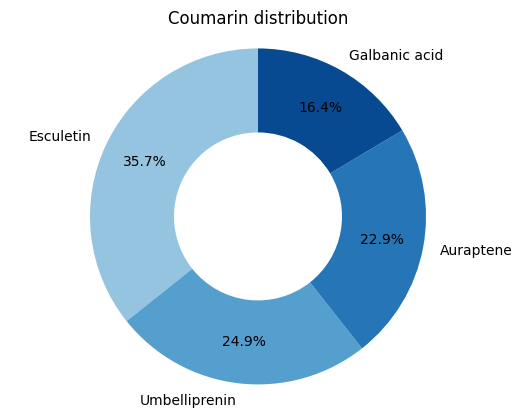

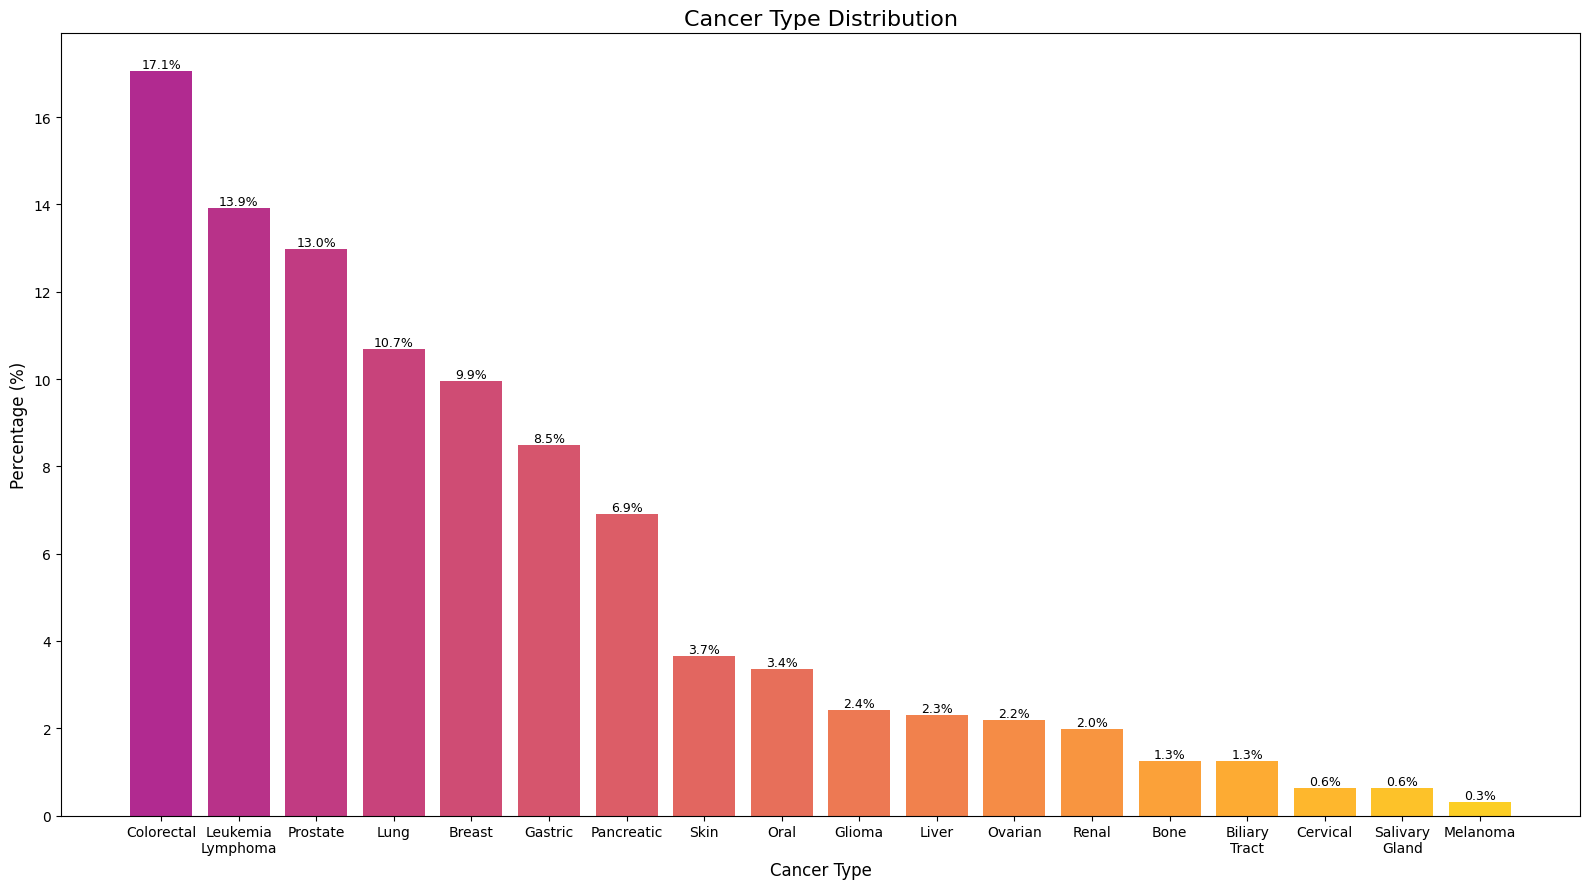

In [ ]:
import pandas as pd;
import numpy as np;
from matplotlib import pyplot as plt;
import matplotlib.cm as cm;
import os

DATA = pd.read_csv("../Total_Data.csv");

# ====<Pie chart for the coumarin distribution in the dataset>====
percentages = DATA["Coumarin Type"].value_counts(normalize=True) * 100;
colors = cm.Blues(np.linspace(0.4, 0.9, len(percentages)))

fig_Coumarin = plt.figure();
ax = fig_Coumarin.add_subplot();
labels = ['Esculetin', 'Umbelliprenin', 'Auraptene', 'Galbanic acid'];
# print(percentages.index)
ax.pie(percentages, labels=labels, 
       autopct='%1.1f%%', startangle=90,
       wedgeprops={'width': 0.5}, pctdistance=0.75,
       colors=colors
       )

ax.set_title("Coumarin distribution");
ax.axis('equal');
plt.show()

# ====<Bar chart for the Cancer Type distribution in the dataset>====

percentages = DATA["Cancer Type"].value_counts(normalize=True) * 100

# Colors
colors = cm.plasma(np.linspace(0.4, 0.9, len(percentages)))

# Plot
plt.figure(figsize=(16, 9))
xaxis = ['Colorectal', 'Leukemia\nLymphoma', 'Prostate', 'Lung', 'Breast', 'Gastric',
       'Pancreatic', 'Skin', 'Oral', 'Glioma', 'Liver', 'Ovarian', 'Renal',
       'Bone', 'Biliary\nTract', 'Cervical', 'Salivary\nGland', 'Melanoma']
bars = plt.bar(
    xaxis,
    percentages.values,
    color=colors,
)

# Add percentage labels on top of bars
for bar, value in zip(bars, percentages.values):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        f"{value:.1f}%",
        ha='center',
        va='bottom',
        fontsize=9
    )

plt.title("Cancer Type Distribution", fontsize=16)
plt.xlabel("Cancer Type", fontsize=12)
plt.ylabel("Percentage (%)", fontsize=12)
plt.tight_layout()
plt.show()